### Extract.py

In [19]:
import os
import csv
import numpy as np

In [2]:
dir_path = "0627_Log"

In [3]:
def extract_number_from_folder(folder_name):
    start = folder_name.find("(") + 1
    end = folder_name.find(")", start)
    return int(folder_name[start:end])

In [4]:
data_array = []
subdirectories = os.listdir(dir_path)
subdirectories = sorted(subdirectories, key=extract_number_from_folder)

In [5]:
for sub_dir in subdirectories: # Iterate through each subdirs
    sub_dir_path = os.path.join(dir_path, sub_dir)
    sub_dir_data = []
    text_files = [f for f in os.listdir(sub_dir_path) if f.endswith('.txt')]
    
    for text_file in text_files: # Iterate through the text files
        file_path = os.path.join(sub_dir_path, text_file)
        
        with open(file_path, 'r') as file:
            file_content = file.readlines()
            sub_dir_data.append(file_content)

    data_array.append(sub_dir_data)

# Now, data_array contains a 2D array with the content of text files
# The number of subdirectories and text files is determined dynamically

In [6]:
def viewRaw(i, j):
    subdirectory_index = i
    text_file_index = j
    if subdirectory_index < len(data_array) and text_file_index < len(data_array[subdirectory_index]):
        print("Content of the selected text file:")
        print("".join(data_array[subdirectory_index][text_file_index]))
    else:
        print("Invalid indices chosen.")

In [7]:
# Iterate through the data_array
for i in range(len(data_array)):
    for j in range(len(data_array[i])):
        file_content = data_array[i][j]
        
        # Remove the last line
        file_content.pop()
        
        # Extract lines starting with $GNGGA or $GPHDT
        extracted_lines = [line for line in file_content if line.startswith('$GNGGA') or line.startswith('$GPHDT')]
        
        # Ensure the first line starts with $GNGGA and the last line with $GPHDT
        if not extracted_lines or not extracted_lines[0].startswith('$GNGGA'):
            extracted_lines.pop(0);
        if not extracted_lines or not extracted_lines[-1].startswith('$GPHDT'):
            extracted_lines.pop();
        
        # Ensure there are an even number of extracted lines
        if len(extracted_lines) % 2 != 0:
            print(f"Odd number of extracted lines in data_array[{i}][{j}].")
        # else:
        #     print("Success.")
        
        # Replace the element in data_array with the extracted lines
        data_array[i][j] = extracted_lines

In [8]:
# Convert dd.mmmmmmmmm... to dd.dddddddd
def ddm2ddd(n):
    d = int(n)
    m_in_d = (n - d) * 5 / 3 # *(100/60)
    return round(d + m_in_d, 8)

In [9]:
# Initialize a list to store the processed data
processed_data = []

# Iterate through data_array
for i in range(len(data_array)):
    
    for j in range(len(data_array[i])):
        file_content = data_array[i][j]
        n = len(file_content) 
        
        # Process pairs of lines starting with "$GNGGA" and "$GPHDT"
        for k in range(0, n, 2):
            if k + 1 < n and file_content[k].startswith('$GNGGA') and file_content[k + 1].startswith('$GPHDT'):
                gngga_line = file_content[k].split(',')
                gphdt_line = file_content[k + 1].split(',')
                
                # Extract the desired fields from $GNGGA and $GPHDT lines
                if len(gngga_line) >= 5 and len(gphdt_line) >= 3:
                    Lat = ddm2ddd(float(gngga_line[2]) / 100)
                    Lon = ddm2ddd(float(gngga_line[4]) / 100)
                    indicator = float(gngga_line[6])
                    HDT = float(gphdt_line[1]) if gphdt_line[1] else -1
                    
                    # Create a new line in the processed data
                    # point_no = i theta_no = j
                    processed_data.append([Lat, Lon, HDT, indicator, i + 1, j * 45])

In [10]:
output_csv_file = 'FromTxt_Raw_Combined.csv' # This used to be processed_data
with open(output_csv_file, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['Lat', 'Lon', 'HDT', 'indicator', 'p_n', 't_n'])  # Add header , 't_x', 't_y', 't_t'
    csv_writer.writerows(processed_data)

print(f"The processed data has been saved to {output_csv_file}.")

The processed data has been saved to FromTxt_Raw_Combined.csv.


### LLToXY.py

In [11]:
file = 'FromTxt_Raw_Combined_Cleaned.csv' # RTK-precision points are cleaned in moderation
NoP = 44; # Number of Points

In [14]:
data = [] # The table to save the content
with open(file, newline='') as csvfile:
    reader = csv.reader(csvfile)
    # Skip the header row
    next(reader)
    for row in reader:
        data.append(row)

divided_data = [[] for _ in range(1, NoP + 1)] # Initialize a 3D list
# i = point number
# j = jth row
# k = the kth field

# Divide the data into NoP parts
for i in range(1, NoP + 1):
    for row in data: # Efficiency can be improved
        if row and int(row[4]) == i: # row[4] is the p_n
            divided_data[i - 1].append(row)


In [15]:
# def printPrecisionLevel(MPS = 0.75, PS = 0.25):
MPP = [] # Most precise points
PP = [] # Precise points
RP = [] # The rest
indicator = 3 # The nth field
MPP_standard = 0.75 # RTK signal should be equal or greater then MPS*100%
PP_standard = 0.05 # PS

# Evaluate the most precise points 
for idx, p in enumerate(divided_data):
    RTK = 0
    for row in p:
        if float(row[indicator]) == 4:
            RTK += 1
        # print(RTK)
    # if len(p) == 0:
    #     RP.append(idx) 
    if RTK / len(p) >= MPP_standard:
        MPP.append(idx)
    elif RTK / len(p) >= PP_standard:
        PP.append(idx)
    else:
        RP.append(idx)

print("MPP: ", MPP)
print("PP:  ", PP)
print("RP:  ", RP)
print()

MPP:  [4, 10, 13, 15, 26, 27, 30, 31, 32, 40]
PP:   [0, 1, 2, 3, 5, 12, 14, 16, 20, 21, 22, 23, 24, 25, 28, 29, 33, 38, 39, 43]
RP:   [6, 7, 8, 9, 11, 17, 18, 19, 34, 35, 36, 37, 41, 42]



In [20]:
# Yield vector <1, 0> and <0, 1> ---------------------------------------------
# Use pt1~5 to determine <1, 0> and pt23~27 to determine <0, 1>
# vecX the lat difference of 1 unit along x
# vecY the lon difference of 1 unit along y

# Average RTK coordinates
P = MPP + PP
avgdFile = 'RTKPointsAveraged.csv'
header = ['Lat', 'Lon', 'indicator', 'p_n'] # Theta field is not included
avgData = []
with open(avgdFile, 'r+', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(header)
    
    for index in P: # Each point
        sumLat = 0
        sumLon = 0
        n = 0
        for line in divided_data[index]: # Each line in a point
            if line[3] == '4':
                n += 1
                sumLat += float(line[0])
                sumLon += float(line[1])

        avgLat = round(sumLat / n, 7)
        avgLon = round(sumLon / n, 7)
        idctr = 4
        csv_writer.writerow([avgLat, avgLon, idctr, index + 1])
        avgData.append([avgLat, avgLon, idctr, index + 1])

avgData = np.array(avgData)
print(avgData)
avgData = avgData[avgData[:, 3].argsort()]
print(avgData)


[[ 25.0130491 121.5411136   4.          5.       ]
 [ 25.0132351 121.5413296   4.         11.       ]
 [ 25.0133161 121.5414226   4.         14.       ]
 [ 25.0133826 121.5413549   4.         16.       ]
 [ 25.0137432 121.5409796   4.         27.       ]
 [ 25.0137758 121.5409457   4.         28.       ]
 [ 25.01367   121.5407833   4.         31.       ]
 [ 25.0136079 121.5407113   4.         32.       ]
 [ 25.013546  121.5406397   4.         33.       ]
 [ 25.0131898 121.5406971   4.         41.       ]
 [ 25.0129261 121.5409683   4.          1.       ]
 [ 25.0129562 121.5410052   4.          2.       ]
 [ 25.0129877 121.5410406   4.          3.       ]
 [ 25.0130184 121.5410771   4.          4.       ]
 [ 25.0130795 121.5411498   4.          6.       ]
 [ 25.0132972 121.5414013   4.         13.       ]
 [ 25.0133489 121.541388    4.         15.       ]
 [ 25.0134158 121.5413213   4.         17.       ]
 [ 25.0135469 121.5411851   4.         21.       ]
 [ 25.0135796 121.541151    4. 

In [22]:
# offset all the points
offset = [-avgData[0][1], -avgData[0][0]] # First row is supposed to be the point 0
print(f"offset: {offset}\n")

vecX = []
p = [1, 2, 3, 4, 5]
for i in p:
    r1 = avgData[avgData[:, 3] == i]
    r2 = avgData[avgData[:, 3] == i + 1]
    diffLat = round(r2[0][0] - r1[0][0], 7)
    diffLon = round(r2[0][1] - r1[0][1], 7)
    vecX.append([diffLon, diffLat])
    
# print(f"vecXs: {vecX}\n")

vecY = []
p = [23, 24, 25, 26, 27]
for i in p:
    r1 = avgData[avgData[:, 3] == i]
    r2 = avgData[avgData[:, 3] == i + 1]
    diffLat = round(r2[0][0] - r1[0][0], 7)
    diffLon = round(r2[0][1] - r1[0][1], 7)
    vecY.append([diffLon, diffLat])

# print(f"vecYs: {vecY}\n")

offset: [-121.5409683, -25.0129261]



In [23]:
vecX = np.array(vecX)
vecY = np.array(vecY)
vecX = vecX / 5
vecY = vecY / 5
vecX = np.mean(vecX, axis=0)
vecY = np.mean(vecY, axis=0)
print(f"Averaged vecX: {vecX}\n")
print(f"Averaged vecY: {vecY}\n")
print(f"vecX dot vecY: {np.dot(vecX, vecY)}\n")

Averaged vecX: [7.260e-06 6.136e-06]

Averaged vecY: [-6.840e-06  6.544e-06]

vecX dot vecY: -9.504415999999996e-12



In [25]:
basis = np.column_stack((vecX, vecY))
header = ['X', 'Y', 'Lat', 'Lon', 'HDT', 'indicator', 'p_n', 't_n']
rawFile = 'FromTxt_Raw_Combined_Cleaned.csv'
transFile = 'Transformed_Combined.csv'

In [26]:
data = [] # The table to save the content
with open(rawFile, newline='') as csvfile:
    reader = csv.reader(csvfile)
    # Skip the header row
    next(reader)
    for row in reader:
        numeric_row = [float(value) for value in row]
        data.append(numeric_row)

with open(transFile, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(header)
    for row in data:
        x = row[1] # Lon
        y = row[0] # Lat
        v = np.array([x + offset[0], y + offset[1]])
        c1, c2 = np.linalg.solve(basis, v)
        c1 = round(c1, 5)
        c2 = round(c2, 5)
        # print([c1, c2])
        csv_writer.writerow([c1, c2, row[0], row[1], row[2], row[3], row[4], row[5]])

### Generate.py

In [37]:
processedFile = 'Transformed_Combined.csv'
completeFile = 'Dataset_Combined.csv'
header = 'X, Y, Lat, Lon, HDT, indicator, p_n, t_n'

In [29]:
n_p = 44 # Number of points
HDTfield = 4
t_nfield = 7

In [32]:
data = []
with open(processedFile, 'r') as file:
    csv_reader = csv.reader(file)
    next(csv_reader, None)
    for row in csv_reader:
        numeric_row = [float(value) for value in row]
        data.append(numeric_row)


In [28]:
def angleConversion(h):
    # 0 <-> 45, 45 <-> 0, 90 <-> 315, 135 <-> 270, 180 <-> 225 ... 
    return (405 - h) % 360

In [33]:
data = np.array(data)
cnt_M1s = np.count_nonzero(data[:, HDTfield] == -1)

In [34]:
def generate_flat_random_numbers(num_samples, range_width):
    flat_values = np.random.uniform(low=-range_width/2, high=range_width/2, size=num_samples)
    flat_values -= np.mean(flat_values) # Adjust the values to have an average of zero
    rounded_values = np.round(flat_values, 3)
    return rounded_values

In [35]:
range_width = 2.6 # +-k -> 2k (+-1.3)
randNums = generate_flat_random_numbers(cnt_M1s, range_width)

In [38]:
n = 0
for row in data:
    if row[HDTfield] == -1:
        # Here the self-defined theta is converted to match HDT orientation
        row[t_nfield] = angleConversion(row[t_nfield])
        fauxHDT = row[t_nfield] + randNums[n]
        if fauxHDT < 0:
            fauxHDT = 360 + fauxHDT
        n += 1
        row[HDTfield] = fauxHDT

# print(data)

np.savetxt(completeFile, data, delimiter=',', header=header, fmt='%.8f', comments='')
print(f'NumPy array has been written to {completeFile}')

NumPy array has been written to Dataset_Combined.csv


### Divide.py

In [40]:
NoP = 44
p_n = 6
t_n = 7
HDT = 4

# Problematic
# vecX = [6.136e-06, 7.260e-06]
# vecY = [6.544e-06, -6.840e-06]
# vecX = np.array(vecX)
# vecY = np.array(vecY)
# vec = (vecX + vecY) / 2 # WTH is this???

In [42]:
unprocessedFile = 'Transformed_Combined.csv'

splitDataDir = r'./Data'

unprocData = []
with open(unprocessedFile, 'r') as csvFile:
    csv_reader = csv.reader(csvFile)
    next(csv_reader, None)
    for row in csv_reader:
        numeric_row = [float(value) for value in row]
        unprocData.append(numeric_row)

# print(unprocData)

In [66]:
divided_data = [[[] for _ in range(8)] for _ in range(1, NoP + 1)] # Initialize a 4D list
#                ^ A 2D list in there
# i = point number
# j = theta number
# k = kth row in the current (i, j)
# m = the mth field

# Divide the data into NoP parts
# for i in range(1, NoP + 1):
#     for row in unprocData: # Efficiency can be improved
#         if row and int(row[p_n]) == i: # row[6] is the p_n
#             divided_data[i - 1].append(row)

# xx = 0
for i in range(1, NoP + 1): # 1~44
    for j in range(8): # 0~7 (0~315)
        # For a set of x y t
        for row in unprocData: # Efficiency is supposed to be improved...
            if row and int(row[p_n]) == i: # row[6] is the p_n
                if int(row[t_n]) == j * 45:
                    divided_data[i - 1][j].append(row)
                    # if int(row[p_n]) == 44 and int(row[t_n]) == 7 * 45:
                    #     print(xx)
                    #     xx += 1

In [44]:
angle = [45, 0, 315, 270, 225, 180, 135, 90]
# Despite many problems with the "truth", we use the assumption we made
# 1st way
# two [0, 75]s will have problems
truth = [[0, 0], [5, 0], [10, 0], [15, 0], [20, 0], [25, 0], [30, 0], [35, 0]
         , [40, 0], [45, 0], [50, 0], [55, 0], [60, 0], [63, 0], [63, 5], [63, 10]
         , [63, 15], [63, 20], [63, 25], [63, 30], [63, 35], [63, 40], [63, 45], [63, 50]
         , [63, 55], [63, 60], [63, 65], [63, 70], [63, 75], [53, 75], [43, 75], [33, 75]
         , [23, 75], [13, 75], [3, 75], [0, 75], [0, 72], [0, 70], [0, 60], [0, 50]
         , [0, 40], [0, 30], [0, 20], [0, 10]
         ] # x y t
# 2nd way
# truth = []
# truth_path = '.\\Truth_All\\truth.csv'
# with open(truth_path, newline='') as csvfile:
#     reader = csv.reader(csvfile)
#     # Skip the header row
#     next(reader)
#     for row in reader:
#         truth.append([row[0], row[1]])

# print(truth)
# sys.exit(0)

In [48]:
# Create the directory if it doesn't exist
if not os.path.exists(splitDataDir):
    os.makedirs(splitDataDir)

fileNames = []
# Create many txt files
for tuple in truth:
    for a in angle:
        fileName = ''
        fileName += str(tuple[0])
        fileName += '_'
        fileName += str(tuple[1])
        fileName += '_'
        fileName += str(a)
        fileName += '.csv'
        fileNames.append(fileName)

# print(fileNames)

In [63]:
divided_data[43][4:8] # Nothing here?

[[], [], [], []]

In [ ]:
cnt = 0
for fn in fileNames: # For each p_n t_n
    filePath = os.path.join(splitDataDir, fn)
    # print(cnt // 8, ' ', cnt % 8)
    with open(filePath, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        # Write truth -> x y t as file name
        # Write est. -> x' y' t' as content of the file
        for row in divided_data[cnt // 8][cnt % 8]:
            theta = angleConversion(row[HDT]) # Unify angle calculation
            # thetaP45 = theta + 45
            # row.append([theta, thetaP45])
            # newRow = [[] for _ in range()]
            csv_writer.writerow([row[0], row[1], row[4]])

    cnt += 1

### Visualize the points 

In [78]:
import matplotlib.pyplot as plt
import pandas as pd

In [73]:
current_directory = os.getcwd()
directory = 'Data'

In [77]:
csv_files = [file for file in os.listdir(os.path.join(current_directory, directory)) if file.endswith('.csv')]
csv_files

['0_0_0.csv',
 '0_0_135.csv',
 '0_0_180.csv',
 '0_0_225.csv',
 '0_0_270.csv',
 '0_0_315.csv',
 '0_0_45.csv',
 '0_0_90.csv',
 '0_10_0.csv',
 '0_10_135.csv',
 '0_10_180.csv',
 '0_10_225.csv',
 '0_10_270.csv',
 '0_10_315.csv',
 '0_10_45.csv',
 '0_10_90.csv',
 '0_20_0.csv',
 '0_20_135.csv',
 '0_20_180.csv',
 '0_20_225.csv',
 '0_20_270.csv',
 '0_20_315.csv',
 '0_20_45.csv',
 '0_20_90.csv',
 '0_30_0.csv',
 '0_30_135.csv',
 '0_30_180.csv',
 '0_30_225.csv',
 '0_30_270.csv',
 '0_30_315.csv',
 '0_30_45.csv',
 '0_30_90.csv',
 '0_40_0.csv',
 '0_40_135.csv',
 '0_40_180.csv',
 '0_40_225.csv',
 '0_40_270.csv',
 '0_40_315.csv',
 '0_40_45.csv',
 '0_40_90.csv',
 '0_50_0.csv',
 '0_50_135.csv',
 '0_50_180.csv',
 '0_50_225.csv',
 '0_50_270.csv',
 '0_50_315.csv',
 '0_50_45.csv',
 '0_50_90.csv',
 '0_60_0.csv',
 '0_60_135.csv',
 '0_60_180.csv',
 '0_60_225.csv',
 '0_60_270.csv',
 '0_60_315.csv',
 '0_60_45.csv',
 '0_60_90.csv',
 '0_70_0.csv',
 '0_70_135.csv',
 '0_70_180.csv',
 '0_70_225.csv',
 '0_70_270.csv',
 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


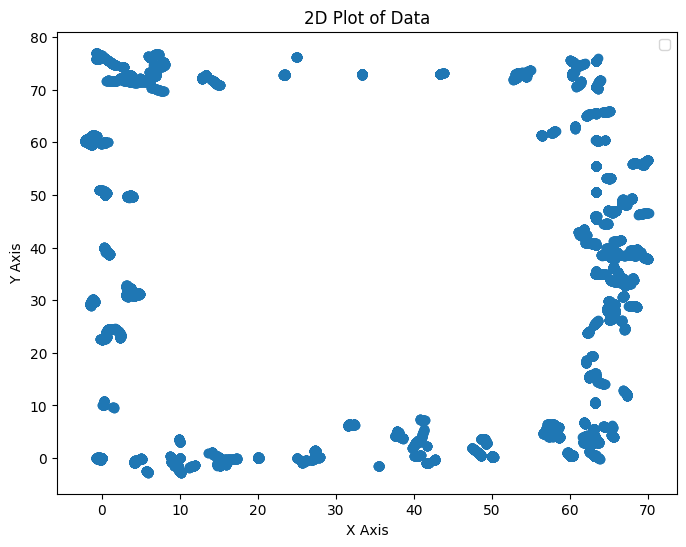

In [80]:
x_values = []
y_values = []

for file in csv_files:
    file_path = os.path.join(current_directory, directory, file)
    
    # Check if the file is empty
    if os.path.getsize(file_path) > 0:
        df = pd.read_csv(file_path, header=None)  # Don't use header
        x_values.extend(df.iloc[:, 0].tolist())  # Extract first column as x
        y_values.extend(df.iloc[:, 1].tolist())  # Extract second column as y
    else:
        print(f"Warning: File {file} is empty and will be skipped.")

if len(x_values) > 0 and len(y_values) > 0:
    # Plotting the data
    plt.figure(figsize=(8, 6))
    plt.title('2D Plot of Data')
    plt.xlabel('X Axis')
    plt.ylabel('Y Axis')
    plt.legend()

    plt.scatter(x_values, y_values, label='Data Points')
    plt.show()
else:
    print("Error: No valid data points found to plot.")
